<center><h1> Darknet traffic dataset </h1> </center>

# Libraries importing and configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipinfo
import json

from category_encoders.hashing import HashingEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm

In [2]:
ipinfo_handler = ipinfo.getHandler("de30fe3213f197")

random_state = 42
dataset_folder = "dataset/" 

pd.options.mode.chained_assignment = None  # default='warn'
np.random.seed(random_state)
plt.rcParams['figure.figsize'] = (18,6)
plt.rcParams["savefig.format"] = 'pdf'
plt.rcParams["savefig.dpi"] = 600
plt.rcParams.update({'font.size': 12})

In [3]:
data = pd.read_csv(dataset_folder + "Darknet.CSV", low_memory=False)

# Dataset processing

## Labels duplicates correction

In [4]:
samples = data.copy()

traffic_labels = samples["Label"].unique()
print(traffic_labels)
traffic_type_labels = samples["Label.1"].unique()
print(traffic_type_labels)

['Non-Tor' 'NonVPN' 'Tor' 'VPN']
['AUDIO-STREAMING' 'Browsing' 'Chat' 'Email' 'File-Transfer'
 'File-transfer' 'P2P' 'Video-Streaming' 'Audio-Streaming'
 'Video-streaming' 'VOIP']


In [5]:
samples['Label.1'].loc[samples['Label.1'] == 'AUDIO-STREAMING'] = 'Audio-Streaming'
samples['Label.1'].loc[samples['Label.1'] == 'File-transfer'] = 'File-Transfer'
samples['Label.1'].loc[samples['Label.1'] == 'Video-streaming'] = 'Video-Streaming'

traffic_type_labels = samples["Label.1"].unique()
print(traffic_type_labels)

['Audio-Streaming' 'Browsing' 'Chat' 'Email' 'File-Transfer' 'P2P'
 'Video-Streaming' 'VOIP']


## Labels grouping in Benign and Darknet

In [6]:
samples['Label'].loc[(samples['Label'] == 'Non-Tor') | (samples['Label'] == 'NonVPN')] = 'Benign'
samples['Label'].loc[(samples['Label'] == 'Tor') | (samples['Label'] == 'VPN')] = 'Darknet'

traffic_labels = samples["Label"].unique()
print(traffic_labels)

['Benign' 'Darknet']


## Timestamp feature extraction

In [7]:
hours = []
for timestamp in samples['Timestamp']:
    hora = int(timestamp.split()[1].split(':')[0])
    hours.append(hora)
samples['hour'] = hours
print(samples[['Timestamp', 'hour']][:5])

                Timestamp  hour
0  24/07/2015 04:09:48 PM     4
1  24/07/2015 04:09:48 PM     4
2  24/07/2015 04:09:48 PM     4
3  24/07/2015 04:09:48 PM     4
4  24/07/2015 04:09:45 PM     4


## Source and destination ips feature extraction

### 1-gram, 2-gram and 3-gram extraction

In [8]:
def create_grams(ip):
    parts = ip.split('.')
    one_gram = parts[0]
    two_gram = parts[0] + " " + parts[1]
    three_gram = parts[0] + " " + parts[1] + " " + parts[2]
    return one_gram, two_gram, three_gram

In [9]:
src_one_gram = []
src_two_gram = []
src_three_gram = []
dst_one_gram = []
dst_two_gram = []
dst_three_gram = []

for src_ip, dst_ip in zip(samples["Src IP"], samples["Dst IP"]): 
    src_one, src_two, src_three = create_grams(src_ip)
    src_one_gram.append(src_one)
    src_two_gram.append(src_two)
    src_three_gram.append(src_three)
    dst_one, dst_two, dst_three = create_grams(dst_ip)
    dst_one_gram.append(dst_one)
    dst_two_gram.append(dst_two)
    dst_three_gram.append(dst_three)

samples["src_ip_1gram"] = src_one_gram
samples["src_ip_2gram"] = src_two_gram
samples["src_ip_3gram"] = src_three_gram

samples["dst_ip_1gram"] = dst_one_gram
samples["dst_ip_2gram"] = dst_two_gram
samples["dst_ip_3gram"] = dst_three_gram

#print(samples[["Src IP","src_ip_1gram","src_ip_2gram","src_ip_3gram"]][200:205])
#print(samples[["Dst IP","dst_ip_1gram","dst_ip_2gram","dst_ip_3gram"]][:5])

### Ips details extraction

In [10]:
def get_ip_detail(ip, ip_dict, repeated):
    if ip not in ip_dict.keys():
        details = ipinfo_handler.getDetails(ip)
        ip_dict[ip] = details.all
    else:
        repeated += 1
    return repeated

def dump_ips(ip_dict, folder):
    j = json.dumps(ip_dict)
    f = open(folder+"ips_dict.json","w")
    f.write(j)
    f.close()

def load_ips(file):
    data = {}
    with open(file) as json_file:
        data = json.load(json_file)
    return data

In [11]:
ip_dict = load_ips("ips_dict.json")

In [12]:
ips = np.concatenate((samples["Src IP"].unique(), samples["Dst IP"].unique())) 
for i in tqdm(range(len(ips))):
    get_ip_detail(ips[i], ip_dict, 0)
dump_ips(ip_dict, "")

100%|██████████| 11111/11111 [00:00<00:00, 417596.30it/s]


In [13]:
ips_tuple = zip(samples["Src IP"], samples["Dst IP"])
dst_ip_country = []
src_ip_country = []
src_bogon = []
dst_bogon = []

for src_ip, dst_ip in tqdm(ips_tuple, total=len(samples["Src IP"])):
    if 'country' in ip_dict[dst_ip].keys():
        dst_ip_country.append(ip_dict[dst_ip]['country'])
    else:
        dst_ip_country.append("")
    if 'country' in ip_dict[src_ip].keys():
        src_ip_country.append(ip_dict[src_ip]['country'])
    else:
        src_ip_country.append("")
    if 'bogon' in ip_dict[dst_ip].keys():
        dst_bogon.append(ip_dict[dst_ip]['bogon'])
    else:
        dst_bogon.append(False)
    if 'bogon' in ip_dict[src_ip].keys():
        src_bogon.append(ip_dict[src_ip]['bogon'])
    else:
        src_bogon.append(False)
samples['src_ip_country'] = src_ip_country
samples['dst_ip_country'] = dst_ip_country
samples['src_bogon'] = src_bogon
samples['dst_bogon'] = dst_bogon

100%|██████████| 141530/141530 [00:00<00:00, 409339.64it/s]


## Irrelevant attributes extraction

In [14]:
model_samples = samples.copy()

del model_samples['Flow ID']
del model_samples['Timestamp']
del model_samples['Src IP']
del model_samples['Dst IP']

In [15]:
cols = np.concatenate((model_samples.columns[81:], model_samples.columns[:81]))
model_samples = model_samples[cols]

In [16]:
model_samples.columns

Index(['hour', 'src_ip_1gram', 'src_ip_2gram', 'src_ip_3gram', 'dst_ip_1gram',
       'dst_ip_2gram', 'dst_ip_3gram', 'src_ip_country', 'dst_ip_country',
       'src_bogon', 'dst_bogon', 'Src Port', 'Dst Port', 'Protocol',
       'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Pac

## Categorical features encoding

In [17]:
hash_enc_cols = ['src_ip_1gram', 'src_ip_2gram', 'src_ip_3gram', 'dst_ip_1gram',
 'dst_ip_2gram', 'dst_ip_3gram']
print(hash_enc_cols)
ord_enc_cols = ['src_ip_country','dst_ip_country']
print(ord_enc_cols)

['src_ip_1gram', 'src_ip_2gram', 'src_ip_3gram', 'dst_ip_1gram', 'dst_ip_2gram', 'dst_ip_3gram']
['src_ip_country', 'dst_ip_country']


In [18]:
hash_enc = HashingEncoder(cols=hash_enc_cols, n_components=100).fit(model_samples)
model_samples = hash_enc.transform(model_samples)
model_samples.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign,Audio-Streaming
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign,Audio-Streaming
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign,Audio-Streaming
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign,Audio-Streaming
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.437760e+15,3117718.131,1.437760e+15,1.437760e+15,Benign,Audio-Streaming


In [19]:
ord_enc = OrdinalEncoder()
ord_enc.fit(model_samples[ord_enc_cols])
model_samples[ord_enc_cols] = ord_enc.transform(model_samples[ord_enc_cols])
model_samples[ord_enc_cols] = model_samples[ord_enc_cols].astype(int)
model_samples[ord_enc_cols].head() 

,src_ip_country,dst_ip_country
0,0,134
1,0,134
2,0,134
3,0,134
4,0,134


In [20]:
model_samples_l1 = model_samples.copy()
model_samples_l1 = model_samples_l1[model_samples_l1['Label'] == "Darknet"]
del model_samples['Label.1']
del model_samples_l1['Label']
model_samples.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,0,0,0,0,0,0,0,0,...,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign
1,0,0,0,0,0,0,0,0,0,0,...,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign
2,0,0,0,0,0,0,0,0,0,0,...,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign
3,0,0,0,0,0,0,0,0,0,0,...,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign
4,0,0,0,0,0,0,0,0,0,0,...,20,0,0,0,0,1.437760e+15,3117718.131,1.437760e+15,1.437760e+15,Benign


In [21]:
model_samples_l1.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label.1
117219,0,0,0,0,0,0,0,0,0,0,...,20,0,0,0,0,1.456330e+15,3.683488e+07,1.456330e+15,1.456330e+15,Audio-Streaming
117220,0,0,0,0,0,0,0,0,0,0,...,20,0,0,0,0,1.456330e+15,3.558961e+07,1.456330e+15,1.456330e+15,Audio-Streaming
117221,0,0,0,0,0,0,0,0,0,0,...,20,0,0,0,0,1.456330e+15,3.301057e+07,1.456330e+15,1.456330e+15,Audio-Streaming
117222,0,0,0,0,0,0,0,0,0,0,...,20,0,0,0,0,1.456330e+15,5.227810e+05,1.456330e+15,1.456330e+15,Audio-Streaming
117223,0,0,0,0,0,0,0,0,0,0,...,20,0,0,0,0,1.456330e+15,1.052330e+05,1.456330e+15,1.456330e+15,Audio-Streaming


In [22]:
print(model_samples_l1.columns)
print(model_samples.columns)

Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'col_8', 'col_9',
       ...
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min',
       'Label.1'],
      dtype='object', length=185)
Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'col_8', 'col_9',
       ...
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Label'],
      dtype='object', length=185)


In [23]:
model_samples = model_samples.replace([np.inf, -np.inf], np.nan)
model_samples_l1 = model_samples_l1.replace([np.inf, -np.inf], np.nan)

model_samples = model_samples.dropna()
model_samples_l1 = model_samples_l1.dropna()
len(model_samples)

141483

## Numerical features scaling

In [24]:
real_columns = ['Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg', 'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg', 'Bwd Packet/Bulk Avg', 'Bwd Bulk Rate Avg', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'FWD Init Win Bytes', 'Bwd Init Win Bytes', 'Fwd Act Data Pkts', 'Fwd Seg Size Min']
print(real_columns)

['Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average

In [25]:
model_samples[real_columns] = model_samples[real_columns].astype(np.float64)
model_samples[real_columns] = model_samples[real_columns].replace([np.inf, -np.inf], np.nan)
model_samples[real_columns] = model_samples[real_columns].dropna()

model_samples_l1[real_columns] = model_samples_l1[real_columns].astype(np.float64)
model_samples_l1[real_columns] = model_samples_l1[real_columns].replace([np.inf, -np.inf], np.nan)
model_samples_l1[real_columns] = model_samples_l1[real_columns].dropna()

In [26]:
df1 = model_samples[model_samples.isna().any(axis=1)]
model_samples = model_samples.drop(df1.index)

df1 = model_samples_l1[model_samples_l1.isna().any(axis=1)]
model_samples_l1 = model_samples_l1.drop(df1.index)

In [27]:
scaler = StandardScaler().fit(model_samples[real_columns])
model_samples[real_columns] = scaler.transform(model_samples[real_columns])
model_samples_l1[real_columns] = scaler.transform(model_samples_l1[real_columns])

In [28]:
model_samples[real_columns].head()

,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min
0,-0.546508,-0.063838,-0.044949,-0.034644,-0.028574,-0.321759,-0.498852,-0.316449,-0.379416,-0.292366,...,-0.052228,-0.043209,-0.634075,-0.313203,0.0,-0.413046,-0.345303,-0.095141,-0.061219,0.589647
1,-0.546503,-0.063838,-0.044949,-0.034644,-0.028574,-0.321759,-0.498852,-0.316449,-0.379416,-0.292366,...,-0.052228,-0.043209,-0.634075,-0.313203,0.0,-0.413046,-0.335704,-0.095141,-0.061219,0.589647
2,-0.546502,-0.063838,-0.044949,-0.034644,-0.028574,-0.321759,-0.498852,-0.316449,-0.379416,-0.292366,...,-0.052228,-0.043209,-0.634075,-0.313203,0.0,-0.413046,-0.329439,-0.095141,-0.061219,0.589647
3,-0.546504,-0.063838,-0.044949,-0.034644,-0.028574,-0.321759,-0.498852,-0.316449,-0.379416,-0.292366,...,-0.052228,-0.043209,-0.634075,-0.313203,0.0,-0.413046,-0.333582,-0.095141,-0.061219,0.589647
4,-0.263585,0.184194,0.071741,-0.014801,-0.027116,-0.120075,-0.498852,0.179861,-0.247304,0.340530,...,0.164343,-0.036900,-0.634075,0.158678,0.0,-0.368398,-0.396835,0.073134,0.305786,0.589647


## Processed dataset

In [29]:
print(samples.columns[:5])
print(f"Number of features: {len(samples.columns)}")

Index(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port'], dtype='object')
Number of features: 96


In [30]:
samples.dtypes[:40]

Flow ID                        object
Src IP                         object
Src Port                        int64
Dst IP                         object
Dst Port                        int64
Protocol                        int64
Timestamp                      object
Flow Duration                   int64
Total Fwd Packet                int64
Total Bwd packets               int64
Total Length of Fwd Packet      int64
Total Length of Bwd Packet      int64
Fwd Packet Length Max           int64
Fwd Packet Length Min           int64
Fwd Packet Length Mean        float64
Fwd Packet Length Std         float64
Bwd Packet Length Max           int64
Bwd Packet Length Min           int64
Bwd Packet Length Mean        float64
Bwd Packet Length Std         float64
Flow Bytes/s                   object
Flow Packets/s                 object
Flow IAT Mean                 float64
Flow IAT Std                  float64
Flow IAT Max                    int64
Flow IAT Min                    int64
Fwd IAT Tota

In [31]:
samples.dtypes[40:81]

Fwd Header Length           int64
Bwd Header Length           int64
Fwd Packets/s             float64
Bwd Packets/s             float64
Packet Length Min           int64
Packet Length Max           int64
Packet Length Mean        float64
Packet Length Std         float64
Packet Length Variance    float64
FIN Flag Count              int64
SYN Flag Count              int64
RST Flag Count              int64
PSH Flag Count              int64
ACK Flag Count              int64
URG Flag Count              int64
CWE Flag Count              int64
ECE Flag Count              int64
Down/Up Ratio               int64
Average Packet Size       float64
Fwd Segment Size Avg      float64
Bwd Segment Size Avg      float64
Fwd Bytes/Bulk Avg          int64
Fwd Packet/Bulk Avg         int64
Fwd Bulk Rate Avg           int64
Bwd Bytes/Bulk Avg          int64
Bwd Packet/Bulk Avg         int64
Bwd Bulk Rate Avg           int64
Subflow Fwd Packets         int64
Subflow Fwd Bytes           int64
Subflow Bwd Pa

In [32]:
samples.dtypes[81:]

Idle Max          float64
Idle Min          float64
Label              object
Label.1            object
hour                int64
src_ip_1gram       object
src_ip_2gram       object
src_ip_3gram       object
dst_ip_1gram       object
dst_ip_2gram       object
dst_ip_3gram       object
src_ip_country     object
dst_ip_country     object
src_bogon            bool
dst_bogon            bool
dtype: object

In [33]:
samples.to_csv(dataset_folder+"darknet_processado.csv")
samples.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,src_ip_1gram,src_ip_2gram,src_ip_3gram,dst_ip_1gram,dst_ip_2gram,dst_ip_3gram,src_ip_country,dst_ip_country,src_bogon,dst_bogon
0,10.152.152.11-216.58.220.99-57158-443-6,10.152.152.11,57158,216.58.220.99,443,6,24/07/2015 04:09:48 PM,229,1,1,...,10,10 152,10 152 152,216,216 58,216 58 220,,US,True,False
1,10.152.152.11-216.58.220.99-57159-443-6,10.152.152.11,57159,216.58.220.99,443,6,24/07/2015 04:09:48 PM,407,1,1,...,10,10 152,10 152 152,216,216 58,216 58 220,,US,True,False
2,10.152.152.11-216.58.220.99-57160-443-6,10.152.152.11,57160,216.58.220.99,443,6,24/07/2015 04:09:48 PM,431,1,1,...,10,10 152,10 152 152,216,216 58,216 58 220,,US,True,False
3,10.152.152.11-74.125.136.120-49134-443-6,10.152.152.11,49134,74.125.136.120,443,6,24/07/2015 04:09:48 PM,359,1,1,...,10,10 152,10 152 152,74,74 125,74 125 136,,US,True,False
4,10.152.152.11-173.194.65.127-34697-19305-6,10.152.152.11,34697,173.194.65.127,19305,6,24/07/2015 04:09:45 PM,10778451,591,400,...,10,10 152,10 152 152,173,173 194,173 194 65,,US,True,False


# Dataset analysis

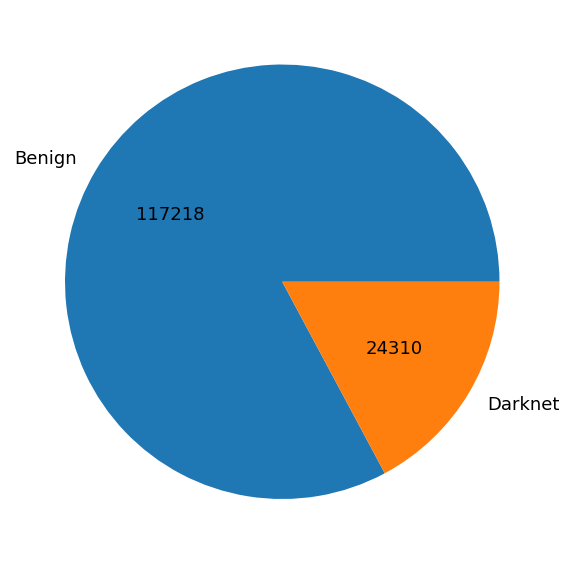

In [34]:
to_analyse = samples.copy()

df = to_analyse.groupby("Label").count()
print()
fig, ax = plt.subplots(figsize=(8,8))

df.plot(y="Label.1", legend=None, ax=ax, shadow=False, kind="pie", fontsize=18,autopct=lambda x: int(df["Label.1"].values.sum()*x/100))
plt.ylabel("")
plt.tight_layout()
plt.savefig('distr_dados_ref')
plt.show()

## Labels probability distribution

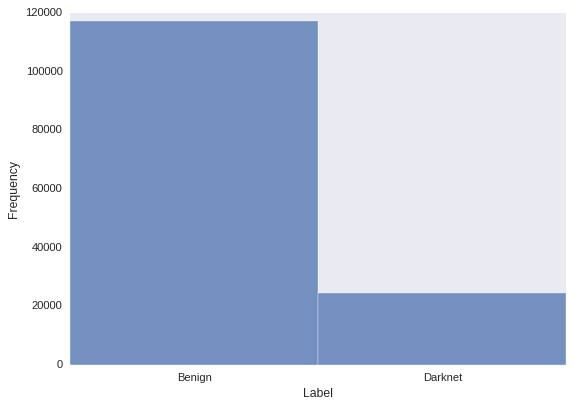

In [50]:
sns.histplot(data=to_analyse, x="Label", stat="frequency")
plt.show()

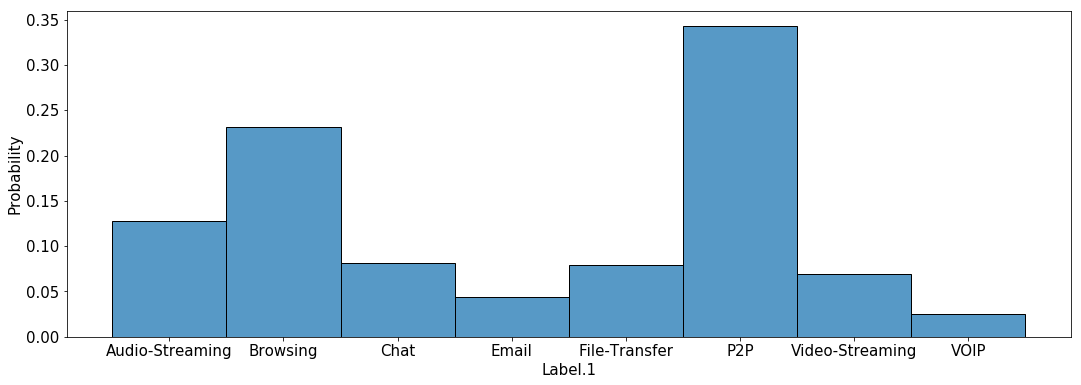

In [271]:
sns.histplot(data=to_analyse, x="Label.1", stat="probability")
plt.show()

## Traffic type on Darknet and outside

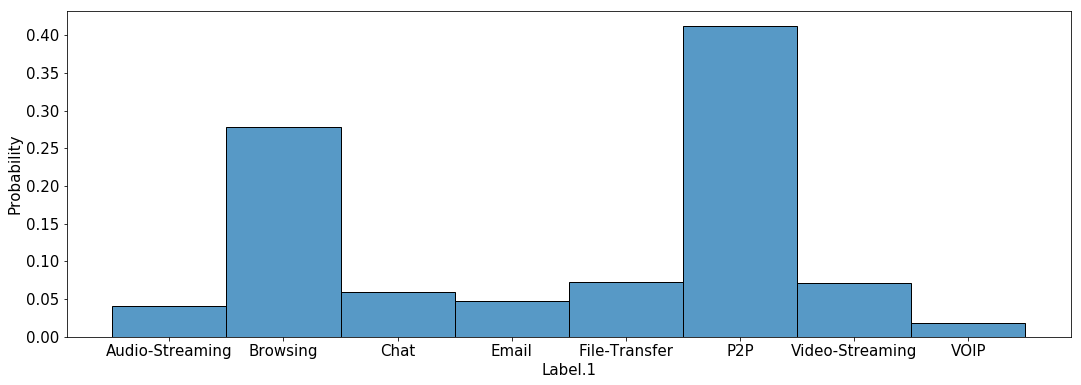

In [272]:
sns.histplot(data=to_analyse[to_analyse['Label'] == "Benign"], x="Label.1", stat="probability")
plt.show()

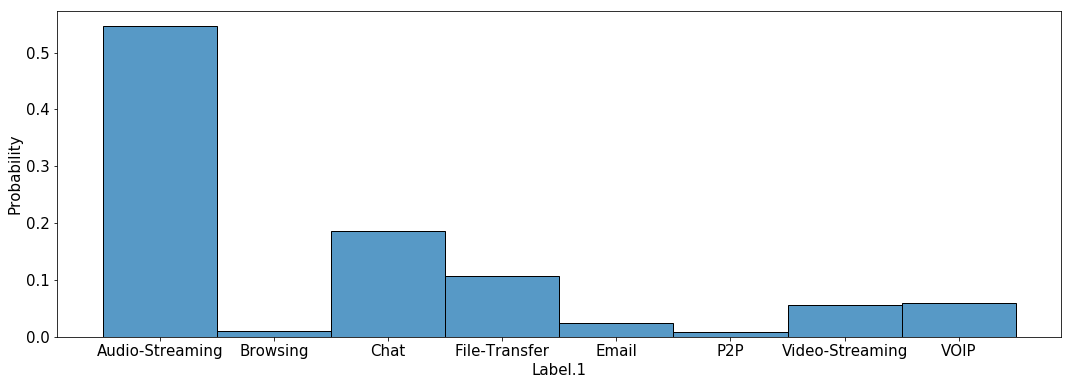

In [273]:
sns.histplot(data=to_analyse[to_analyse['Label'] == "Darknet"], x="Label.1", stat="probability")
plt.show()

## Access hour

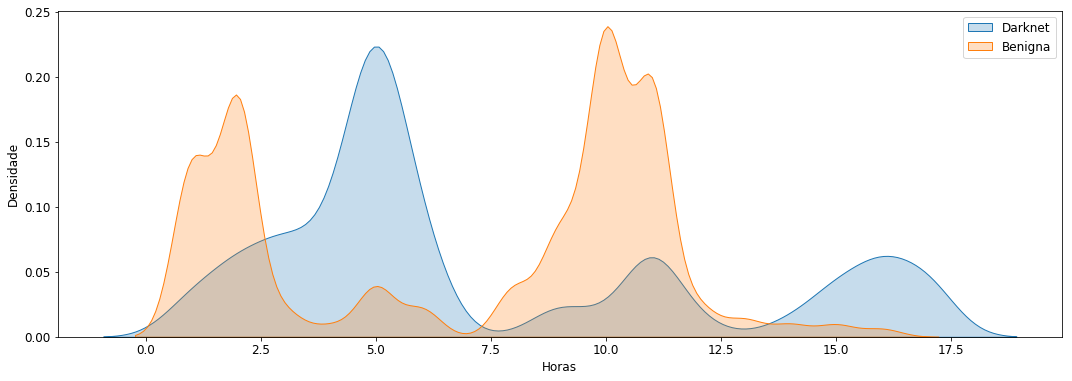

In [372]:
plot_graph_darknet = to_analyse[to_analyse['Label'] == "Darknet"]
plot_graph_benign = to_analyse[to_analyse['Label'] == "Benign"]
sns.kdeplot(plot_graph_darknet['hour'], shade=True)
sns.kdeplot(plot_graph_benign['hour'], shade=True)
plt.xlabel("Horas")
plt.ylabel("Densidade")
plt.legend(['Darknet', 'Benigna'])
plt.savefig('hour_relationship2')
plt.show()

# Models evaluation

In [276]:
def split_train_target(samples, labels_col):
    X = samples.copy()
    del X[labels_col]
    X = X.values
    y = samples[labels_col].values
    labels = np.unique(samples[labels_col])
    return X, y, labels

In [277]:
def kfold_validation(model, X, y, labels=None, n_splits=10, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    classifier_reports = []
    for train_index, test_index in tqdm(skf.split(X, y), total=n_splits): 
        x_train_fold, x_test_fold = X[train_index], X[test_index] 
        y_train_fold, y_test_fold = y[train_index], y[test_index] 
        model = model.fit(x_train_fold,y_train_fold)
        y_pred_fold = model.predict(x_test_fold)
        class_report = classification_report(y_test_fold, y_pred_fold, target_names=labels,
                                             output_dict=True)    
        classifier_reports.append(class_report)
    
    final_report = {}
    for report in classifier_reports:
        for label in report.keys():
            if type(report[label]) == dict:
                if label not in final_report:
                    final_report[label] = {}
                for key in report[label].keys():
                    if key not in final_report[label]:
                            final_report[label][key] = 0.0
                    final_report[label][key] += report[label][key]
            else:
                if label not in final_report:
                    final_report[label] = 0.0
                final_report[label] += report[label]

    for label in final_report.keys():
        if type(final_report[label]) == dict:
            for metric in final_report[label].keys():
                final_report[label][metric] /= n_splits
        else:
            final_report[label] /= n_splits
    final_report["n_splits"] = n_splits
    return final_report

In [278]:
def show_kfold_report(report, labels):
    metrics_printed = False
    n_spaces = max([len(label) for label in labels])
    for label in labels:
        if not metrics_printed:
            print(" "*n_spaces, end='')
            for metric in report[label].keys():
                print(f"{metric}", " "*6,end='')
            metrics_printed = True
            print()
        print(f"{label}: ", " "*(n_spaces-len(label)),end='')
        for metric in report[label].keys():
            print("%0.2f\t\t"%(report[label][metric]*100),end='')
        print()
    print("\n\n", "%d-fold Accuracy: %0.2f%%"%(report["n_splits"],report['accuracy']*100))

In [279]:
def show_confusion_matrix(model, X, y, labels):
    y_pred = model.predict(X)
    conf = confusion_matrix(y, y_pred)
    n_spaces = max([len(label) for label in labels])
    print("Test accuracy: %0.2f%%\n"%(np.sum((y_pred==y))/y.size*100))
    print("\nConfusion matrix:")
    print(conf)
    print()
    for i in range(conf.shape[0]):
        print(labels[i],":"," "*(n_spaces- len(labels[i])) ," %0.2f%%"%(conf[i,i]/np.sum(conf[:,i])*100))

In [361]:
def evaluate_model(model, X_train, y_train, X_test, y_test, labels, n_splits=10, figsize=(10,10), rotation=(35,25),fname="conf_mat"):
    kfold_report = kfold_validation(model, X_train, y_train, n_splits=n_splits)
    show_kfold_report(kfold_report, labels)
    show_confusion_matrix(model, X_test, y_test, labels)
    
    fig, ax = plt.subplots(figsize=figsize)
    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, ax=ax, colorbar=False)
    plt.yticks(rotation=rotation[0], va='top')
    plt.xticks(rotation=rotation[1])
    plt.tight_layout() 
    plt.savefig(fname)
    plt.show()
    return kfold_report

## Benign vs Darknet classification

In [281]:
X, y, labels = split_train_target(model_samples, "Label")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)
columns = model_samples_l1.columns.tolist()

### Decision tree


100%|██████████| 10/10 [01:11<00:00,  7.10s/it]


       precision       recall       f1-score       support       
Benign:   99.94		99.92		99.93		784910.00		
Darknet:  99.64		99.71		99.67		163010.00		


 10-fold Accuracy: 99.89%
Test accuracy: 99.91%


Confusion matrix:
[[38661    18]
 [   22  7988]]

Benign :    99.94%
Darknet :   99.78%


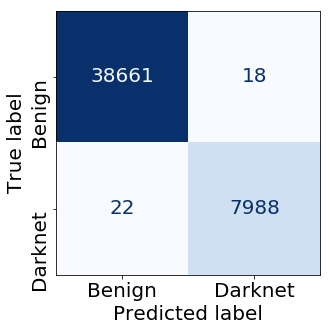

In [362]:
model = DecisionTreeClassifier(random_state=random_state)
report = evaluate_model(model, X_train, y_train, X_test, y_test, labels, figsize=(5,5),rotation=(90, 0), fname="dt_conf_origin")

### Random forest


100%|██████████| 10/10 [04:41<00:00, 28.11s/it]


       precision       recall       f1-score       support       
Benign:   99.89		99.97		99.93		784910.00		
Darknet:  99.87		99.47		99.67		163010.00		


 10-fold Accuracy: 99.89%
Test accuracy: 99.90%


Confusion matrix:
[[38670     9]
 [   36  7974]]

Benign :    99.91%
Darknet :   99.89%


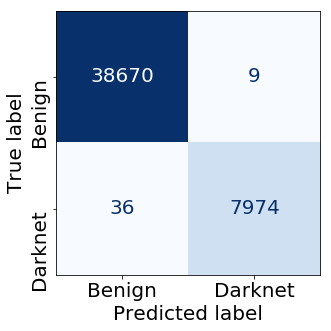

In [364]:
rf_model = RandomForestClassifier(random_state=random_state)
report_rf = evaluate_model(rf_model, X_train, y_train, X_test, y_test, labels, 
                           figsize=(5,5), rotation=(90, 0), fname="rf_conf_origin")

## Darknet traffic caracterization

In [306]:
X1, y1, labels1 = split_train_target(model_samples_l1, "Label.1")
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.33, random_state=random_state)
columns1 = model_samples_l1.columns.tolist()

### Decision tree

100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


               precision       recall       f1-score       support       
Audio-Streaming:  99.60		99.66		99.63		88830.00		
Browsing:         93.05		83.82		87.85		1750.00		
Chat:             98.93		99.28		99.10		30520.00		
Email:            95.33		95.70		95.45		3930.00		
File-Transfer:    98.27		97.92		98.09		17300.00		
P2P:              97.12		96.25		96.48		1570.00		
VOIP:             97.39		97.97		97.68		9860.00		
Video-Streaming:  96.28		96.16		96.21		9120.00		


 10-fold Accuracy: 98.81%
Test accuracy: 99.03%


Confusion matrix:
[[4387    2   12    0    0    0    0    0]
 [   4   80    0    0    1    1    1    1]
 [   5    4 1479    0    0    0    1    0]
 [   0    0    0  184    5    0    0    0]
 [   1    0    0   11  864    0    0    4]
 [   0    0    0    0    0   63    0    0]
 [   0    0    1    0    0    0  473    5]
 [   2    0    1    0    4    2   10  415]]

Audio-Streaming :   99.73%
Browsing :          93.02%
Chat :              99.06%
Email :             94.36%
File-Tr

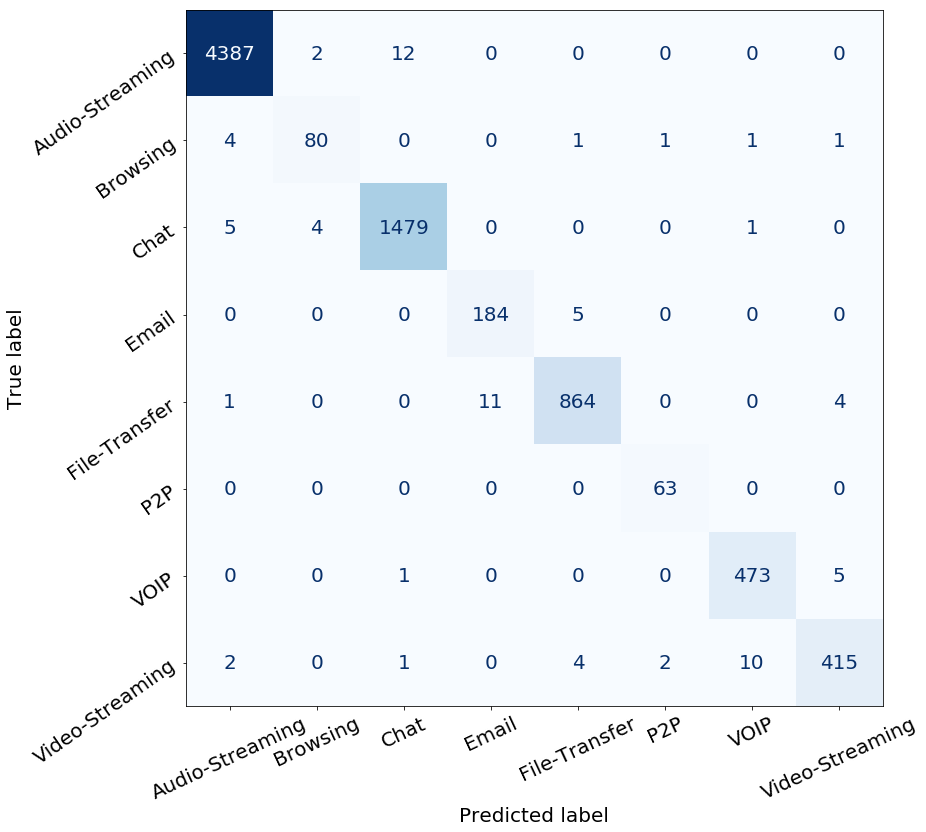

In [356]:
model1 = DecisionTreeClassifier(random_state=random_state)
report1 = evaluate_model(model1, X1_train, y1_train, X1_test, y1_test, labels1, 
                         figsize=(13,13), fname="dt_conf_app")

### Random forest

100%|██████████| 10/10 [00:32<00:00,  3.25s/it]


               precision       recall       f1-score       support       
Audio-Streaming:  99.50		99.08		99.29		88830.00		
Browsing:         88.49		83.95		85.87		1750.00		
Chat:             98.51		99.08		98.79		30520.00		
Email:            98.47		95.94		97.15		3930.00		
File-Transfer:    98.03		96.99		97.50		17300.00		
P2P:              95.67		97.50		96.32		1570.00		
VOIP:             97.13		97.26		97.16		9860.00		
Video-Streaming:  91.32		96.27		93.71		9120.00		


 10-fold Accuracy: 98.34%
Test accuracy: 98.34%


Confusion matrix:
[[4361    2   17    0    6    0    0   15]
 [   6   75    4    0    0    0    1    2]
 [   9    3 1462    0   14    0    0    1]
 [   0    0    1  185    3    0    0    0]
 [  10    0    5    4  859    0    0    2]
 [   2    0    0    0    0   61    0    0]
 [   2    1    1    0    1    0  468    6]
 [   1    2    0    0    2    0   10  419]]

Audio-Streaming :   99.32%
Browsing :          90.36%
Chat :              98.12%
Email :             97.88%
File-Tr

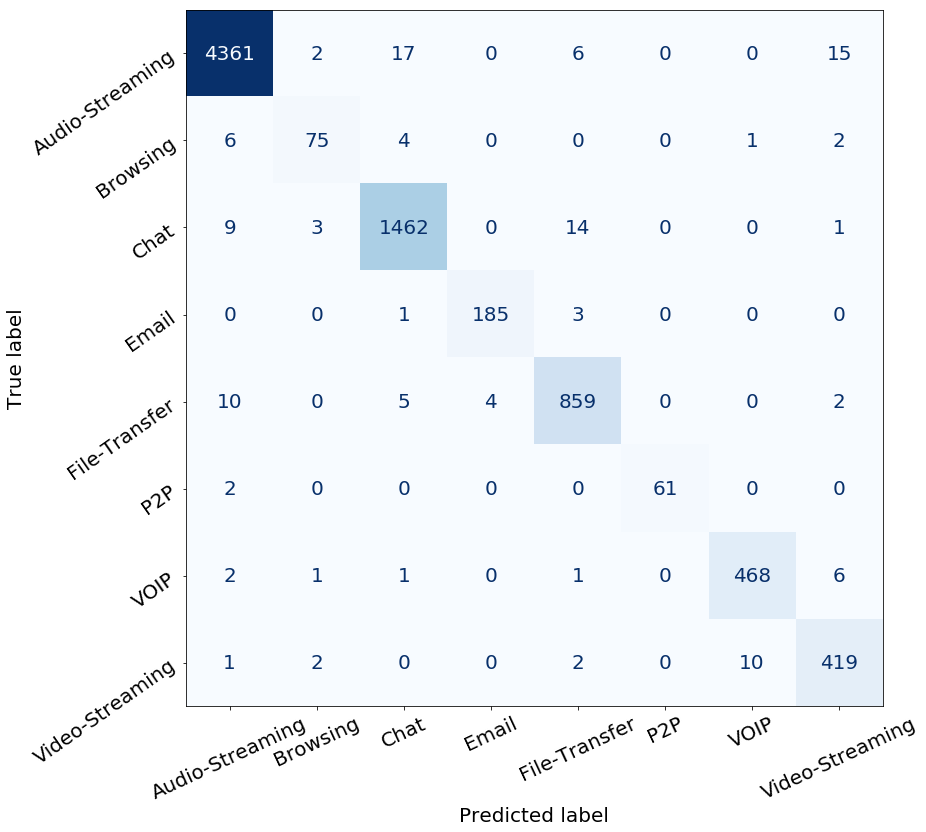

In [357]:
rf_model1 = RandomForestClassifier(random_state=random_state)
report_rf1 = evaluate_model(rf_model1, X1_train, y1_train, X1_test, y1_test, labels1, figsize=(13,13),
                           fname="rf_conf_app")

# Feature selection

## Recursive Feature Elimination (RFE)

In [196]:
def select_features(model, X, y, min_feats=1,step=2, random_state=None):
    rfe = RFECV(model, min_features_to_select=min_feats, step=step, cv=StratifiedKFold(10, shuffle=True, random_state=random_state), scoring='accuracy', n_jobs=4, verbose=3)
    rfe.fit(X, y)
    return rfe

def final_evaluation(model, X, y, labels, rfe):
    X_selected = rfe.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.33, random_state=random_state)
    kfold_report = kfold_validation(model, X_train, y_train, n_splits=10)
    show_kfold_report(kfold_report, np.unique(y_train))
    show_confusion_matrix(model, X_test, y_test, labels)

In [197]:
def summarize_feats(rfe, model, columns, to_remove=[]):
    columns = [column for column in columns if column not in to_remove]
    columns = [columns[i] for i in range(len(columns)) if (i < len(rfe.support_)) 
               and rfe.support_[i] ]
    features = zip(columns, model.feature_importances_)
    feat_import = [(feat, importance) for feat, importance in features]
    feat_import.sort(key = lambda x: x[1], reverse=True)
    
    n_spaces = max([len(feat) for feat, _ in feat_import])
    head = "Feature" + str(" "*(n_spaces-len("Feature")) + "\tImportance") 
    print(head)
    print("-"*(len(head)+5))
    for feature, importance in feat_import:
        print(f"%s:"%(feature)," "*(n_spaces-len(feature)),"\t%0.4f"%(importance))
    
    return columns

### Benign vs Darknet classification

#### Without new features

In [198]:
ben_samples = model_samples.copy()
ben_samples = ben_samples.drop(ben_samples.columns[:105].tolist(),axis=1)
ben_samples.columns

Index(['Src Port', 'Dst Port', 'Protocol', 'Flow Duration', 'Total Fwd Packet',
       'Total Bwd packets', 'Total Length of Fwd Packet',
       'Total Length of Bwd Packet', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN

In [199]:
X2, y2, labels2 = split_train_target(ben_samples, "Label")
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=random_state)
columns2 = ben_samples.columns.tolist()

##### Decision tree

In [200]:
model2 = DecisionTreeClassifier(random_state=random_state)
rfe2 = select_features(model2, X2, y2, 1, step=1)

Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.


In [201]:
final_report2 = final_evaluation(model2, X2, y2, labels2, rfe2)
print()
print(f"Optimal number of features: {rfe2.n_features_}")
selected_columns2 = summarize_feats(rfe2, model2, columns2)

100%|██████████| 10/10 [00:46<00:00,  4.69s/it]


       precision       recall       f1-score       support       
Benign:   98.80		98.81		98.80		784910.00		
Darknet:  94.26		94.20		94.23		163010.00		


 10-fold Accuracy: 98.02%
Test accuracy: 98.15%


Confusion matrix:
[[38236   443]
 [  423  7587]]

Benign :    98.91%
Darknet :   94.48%

Optimal number of features: 68
Feature                   	Importance
------------------------------------------
Bwd Packet Length Min:       	0.3555
Flow IAT Mean:               	0.1229
Fwd Seg Size Min:            	0.1102
Idle Max:                    	0.0783
Bwd Init Win Bytes:          	0.0421
Src Port:                    	0.0392
Flow IAT Max:                	0.0373
Flow IAT Min:                	0.0226
FWD Init Win Bytes:          	0.0190
Fwd Packet Length Min:       	0.0172
Bwd Header Length:           	0.0161
Dst Port:                    	0.0127
Subflow Fwd Bytes:           	0.0115
Flow Duration:               	0.0114
Idle Min:                    	0.0102
Flow Bytes/s:                	0.0098
Fwd

In [202]:
dotfile = open("dtree3.dot", 'w')
export_graphviz(model2, out_file = dotfile, feature_names = selected_columns2)
dotfile.close()

##### Random forest

In [203]:
model_rf = DecisionTreeClassifier(random_state=random_state)
rfe_rf = select_features(model_rf, X2, y2, 1, step=4)

Fitting estimator with 79 features.
Fitting estimator with 75 features.
Fitting estimator with 71 features.
Fitting estimator with 67 features.
Fitting estimator with 63 features.
Fitting estimator with 59 features.
Fitting estimator with 55 features.
Fitting estimator with 51 features.
Fitting estimator with 47 features.


In [204]:
final_report_rf = final_evaluation(model_rf, X2, y2, labels2, rfe_rf)
print()
print(f"Optimal number of features: {rfe_rf.n_features_}")
selected_columns_rf = summarize_feats(rfe_rf, model_rf, columns2)

100%|██████████| 10/10 [00:34<00:00,  3.48s/it]


       precision       recall       f1-score       support       
Benign:   98.80		98.82		98.81		784910.00		
Darknet:  94.31		94.21		94.26		163010.00		


 10-fold Accuracy: 98.03%
Test accuracy: 98.18%


Confusion matrix:
[[38248   431]
 [  421  7589]]

Benign :    98.91%
Darknet :   94.63%

Optimal number of features: 43
Feature                   	Importance
------------------------------------------
Bwd Packet Length Min:       	0.3560
Flow IAT Mean:               	0.1212
Fwd Seg Size Min:            	0.1102
Idle Max:                    	0.0680
Bwd Init Win Bytes:          	0.0423
Src Port:                    	0.0389
Flow IAT Max:                	0.0369
Flow IAT Min:                	0.0230
Idle Min:                    	0.0229
FWD Init Win Bytes:          	0.0190
Fwd Packet Length Min:       	0.0172
Bwd Header Length:           	0.0165
Flow Duration:               	0.0133
Dst Port:                    	0.0130
Subflow Fwd Bytes:           	0.0112
Flow Bytes/s:                	0.0097
Fwd

In [205]:
dotfile = open("rf.dot", 'w')
export_graphviz(model_rf, out_file = dotfile, feature_names = selected_columns_rf)
dotfile.close()

#### With new features

In [206]:
X2, y2, labels2 = split_train_target(model_samples, "Label")
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=random_state)
columns2 = model_samples.columns.tolist()

##### Decision tree

In [207]:
model2 = DecisionTreeClassifier(random_state=random_state)
rfe2 = select_features(model2, X2, y2, 1, step=1)

Fitting estimator with 184 features.
Fitting estimator with 183 features.
Fitting estimator with 182 features.
Fitting estimator with 181 features.
Fitting estimator with 180 features.
Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
Fitting estimator with 173 features.
Fitting estimator with 172 features.
Fitting estimator with 171 features.
Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
F

In [208]:
final_report2 = final_evaluation(model2, X2, y2, labels2, rfe2)
print()
print(f"Optimal number of features: {rfe2.n_features_}")
selected_columns2 = summarize_feats(rfe2, model2, columns2)

100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


       precision       recall       f1-score       support       
Benign:   99.93		99.92		99.92		784910.00		
Darknet:  99.60		99.65		99.63		163010.00		


 10-fold Accuracy: 99.87%
Test accuracy: 99.88%


Confusion matrix:
[[38646    33]
 [   24  7986]]

Benign :    99.94%
Darknet :   99.59%

Optimal number of features: 17
Feature           	Importance
----------------------------------
col_91:              	0.7628
col_49:              	0.1205
Bwd Init Win Bytes:  	0.0422
col_24:              	0.0410
hour:                	0.0140
col_96:              	0.0034
Idle Max:            	0.0024
Idle Std:            	0.0020
Idle Min:            	0.0018
col_45:              	0.0018
Flow IAT Min:        	0.0017
Src Port:            	0.0015
Packet Length Std:   	0.0014
Flow Duration:       	0.0013
col_1:               	0.0009
FWD Init Win Bytes:  	0.0006
src_bogon:           	0.0006


In [209]:
dotfile = open("dtree3.dot", 'w')
export_graphviz(model2, out_file = dotfile, feature_names = selected_columns2)
dotfile.close()

##### Random forest

In [211]:
model_rf = DecisionTreeClassifier(random_state=random_state)
rfe_rf = select_features(model_rf, X2, y2, 1, step=1)

Fitting estimator with 184 features.
Fitting estimator with 183 features.
Fitting estimator with 182 features.
Fitting estimator with 181 features.
Fitting estimator with 180 features.
Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
Fitting estimator with 173 features.
Fitting estimator with 172 features.
Fitting estimator with 171 features.
Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
F

In [212]:
final_report_rf = final_evaluation(model_rf, X2, y2, labels2, rfe_rf)
print()
print(f"Optimal number of features: {rfe_rf.n_features_}")
selected_columns_rf = summarize_feats(rfe_rf, model_rf, columns2)

100%|██████████| 10/10 [00:44<00:00,  4.50s/it]


       precision       recall       f1-score       support       
Benign:   99.93		99.93		99.93		784910.00		
Darknet:  99.64		99.67		99.66		163010.00		


 10-fold Accuracy: 99.88%
Test accuracy: 99.91%


Confusion matrix:
[[38660    19]
 [   21  7989]]

Benign :    99.95%
Darknet :   99.76%

Optimal number of features: 89
Feature                   	Importance
------------------------------------------
col_91:                      	0.7628
col_49:                      	0.1205
Bwd Init Win Bytes:          	0.0418
col_24:                      	0.0410
hour:                        	0.0151
col_96:                      	0.0034
Idle Std:                    	0.0020
Idle Min:                    	0.0019
col_45:                      	0.0018
Idle Max:                    	0.0012
Flow IAT Min:                	0.0009
col_1:                       	0.0009
Src Port:                    	0.0007
src_bogon:                   	0.0006
FWD Init Win Bytes:          	0.0005
Packet Length Std:           	0.0005
Flo

In [ ]:
dotfile = open("rf.dot", 'w')
export_graphviz(model_rf, out_file = dotfile, feature_names = selected_columns_rf)
dotfile.close()

### Darknet traffic caracterization

#### Without new features

In [213]:
l1_samples = model_samples_l1.copy()
l1_samples = l1_samples.drop(l1_samples.columns[:105].tolist(),axis=1)
l1_samples.columns

Index(['Src Port', 'Dst Port', 'Protocol', 'Flow Duration', 'Total Fwd Packet',
       'Total Bwd packets', 'Total Length of Fwd Packet',
       'Total Length of Bwd Packet', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN

In [214]:
X3, y3, labels3 = split_train_target(l1_samples, "Label.1")
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.33, random_state=random_state)
columns3 = l1_samples.columns.tolist()

##### Decision tree

In [215]:
model3 = DecisionTreeClassifier(random_state=random_state)
rfe1 = select_features(model3, X3, y3, 1, step=1)

Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.


In [216]:
final_evaluation(model3, X3, y3, labels3, rfe1)
print()
print(f"Optimal number of features: {rfe1.n_features_}")
selected_columns1 = summarize_feats(rfe1, model3, columns3)

100%|██████████| 10/10 [00:03<00:00,  2.73it/s]

               precision       recall       f1-score       support       
Audio-Streaming:  97.92		97.74		97.83		88830.00		
Browsing:         83.50		81.01		82.13		1750.00		
Chat:             95.85		96.33		96.08		30520.00		
Email:            90.30		90.87		90.44		3930.00		
File-Transfer:    93.84		93.06		93.44		17300.00		
P2P:              93.48		96.88		95.03		1570.00		
VOIP:             94.52		95.33		94.91		9860.00		
Video-Streaming:  85.90		85.75		85.76		9120.00		


 10-fold Accuracy: 95.81%
Test accuracy: 96.04%


Confusion matrix:
[[4323    2   16    2   20    1    6   31]
 [   3   72    6    0    2    1    2    2]
 [  17    4 1424   10   23    0    5    6]
 [   2    0    7  172    6    0    1    1]
 [  12    1   24    2  821    0   13    7]
 [   0    0    0    0    0   63    0    0]
 [   5    1    9    1    6    0  451    6]
 [  39    3    1    0    5    0    7  379]]

Audio-Streaming :   98.23%
Browsing :          86.75%
Chat :              95.76%
Email :             91.98%
File-Tr

In [217]:
dotfile = open("dtree2.dot", 'w')
export_graphviz(model3, out_file = dotfile, feature_names = selected_columns1)
dotfile.close()

##### Random forest

In [218]:
model_rf1 = DecisionTreeClassifier(random_state=random_state)
rfe_rf1 = select_features(model_rf1, X3, y3, 1, step=1)

Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 fe

In [219]:
final_report_rf1 = final_evaluation(model_rf1, X3, y3, labels3, rfe_rf1)
print()
print(f"Optimal number of features: {rfe_rf1.n_features_}")
selected_columns_rf1 = summarize_feats(rfe_rf1, model_rf1, columns3)

100%|██████████| 10/10 [00:01<00:00,  5.15it/s]


               precision       recall       f1-score       support       
Audio-Streaming:  98.12		97.93		98.02		88830.00		
Browsing:         88.67		85.65		86.88		1750.00		
Chat:             96.06		96.23		96.14		30520.00		
Email:            90.85		90.36		90.49		3930.00		
File-Transfer:    93.63		93.18		93.39		17300.00		
P2P:              91.90		98.12		94.84		1570.00		
VOIP:             94.74		95.54		95.11		9860.00		
Video-Streaming:  86.14		86.41		86.20		9120.00		


 10-fold Accuracy: 96.00%
Test accuracy: 95.77%


Confusion matrix:
[[4307    3   21    5   23    1   12   29]
 [   7   70    4    0    2    2    1    2]
 [  26    2 1417    6   21    0    7   10]
 [   0    0    5  174    6    0    3    1]
 [  19    1   15    3  823    0    9   10]
 [   0    0    0    0    0   63    0    0]
 [   5    0    9    1    4    1  452    7]
 [  34    2    5    0    2    0   13  378]]

Audio-Streaming :   97.93%
Browsing :          89.74%
Chat :              96.00%
Email :             92.06%
File-Tr

In [220]:
dotfile = open("rf.dot", 'w')
export_graphviz(model_rf1, out_file = dotfile, feature_names = selected_columns_rf1)
dotfile.close()

#### With new features

In [291]:
X3, y3, labels3 = split_train_target(model_samples_l1, "Label.1")
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.33, random_state=random_state)
columns3 = model_samples_l1.columns.tolist()

##### Decision tree

In [222]:
model3 = DecisionTreeClassifier(random_state=random_state)
rfe1 = select_features(model3, X3, y3, 1, step=1)

Fitting estimator with 184 features.
Fitting estimator with 183 features.
Fitting estimator with 182 features.
Fitting estimator with 181 features.
Fitting estimator with 180 features.
Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
Fitting estimator with 173 features.
Fitting estimator with 172 features.
Fitting estimator with 171 features.
Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
F

In [223]:
final_evaluation(model3, X3, y3, labels3, rfe1)
print()
print(f"Optimal number of features: {rfe1.n_features_}")
selected_columns1 = summarize_feats(rfe1, model3, columns3)

100%|██████████| 10/10 [00:04<00:00,  2.18it/s]

               precision       recall       f1-score       support       
Audio-Streaming:  99.54		99.75		99.65		88830.00		
Browsing:         94.21		83.33		88.26		1750.00		
Chat:             99.25		99.25		99.25		30520.00		
Email:            95.48		96.21		95.80		3930.00		
File-Transfer:    98.50		98.09		98.29		17300.00		
P2P:              96.66		98.75		97.59		1570.00		
VOIP:             97.39		97.56		97.47		9860.00		
Video-Streaming:  96.40		96.27		96.32		9120.00		


 10-fold Accuracy: 98.88%
Test accuracy: 99.10%


Confusion matrix:
[[4387    2   12    0    0    0    0    0]
 [   5   80    0    0    1    1    1    0]
 [   5    4 1480    0    0    0    0    0]
 [   0    0    0  186    3    0    0    0]
 [   1    0    0   11  865    0    0    3]
 [   0    0    0    0    0   63    0    0]
 [   0    0    1    0    0    0  473    5]
 [   3    0    1    0    4    0    9  417]]

Audio-Streaming :   99.68%
Browsing :          93.02%
Chat :              99.06%
Email :             94.42%
File-Tr

In [224]:
dotfile = open("dtree2.dot", 'w')
export_graphviz(model3, out_file = dotfile, feature_names = selected_columns1)
dotfile.close()

##### Random forest

In [225]:
model_rf1 = DecisionTreeClassifier(random_state=random_state)
rfe_rf1 = select_features(model_rf1, X3, y3, 1, step=1)

Fitting estimator with 184 features.
Fitting estimator with 183 features.
Fitting estimator with 182 features.
Fitting estimator with 181 features.
Fitting estimator with 180 features.
Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
Fitting estimator with 173 features.
Fitting estimator with 172 features.
Fitting estimator with 171 features.
Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.


In [226]:
final_report_rf1 = final_evaluation(model_rf1, X3, y3, labels3, rfe_rf1)
print()
print(f"\nOptimal number of features: {rfe_rf1.n_features_}")
selected_columns_rf1 = summarize_feats(rfe_rf1, model_rf1, columns3)

100%|██████████| 10/10 [00:04<00:00,  2.04it/s]

               precision       recall       f1-score       support       
Audio-Streaming:  99.60		99.73		99.66		88830.00		
Browsing:         95.15		86.67		90.43		1750.00		
Chat:             99.22		99.25		99.23		30520.00		
Email:            95.71		96.21		95.92		3930.00		
File-Transfer:    98.46		98.44		98.44		17300.00		
P2P:              97.09		96.88		96.82		1570.00		
VOIP:             97.59		98.07		97.83		9860.00		
Video-Streaming:  97.05		96.49		96.76		9120.00		


 10-fold Accuracy: 98.97%
Test accuracy: 99.04%


Confusion matrix:
[[4387    2   12    0    0    0    0    0]
 [   6   79    0    0    1    1    1    0]
 [   6    5 1478    0    0    0    0    0]
 [   0    0    0  183    6    0    0    0]
 [   0    0    0   11  866    0    0    3]
 [   0    0    0    0    0   63    0    0]
 [   0    0    1    0    0    0  473    5]
 [   4    0    0    0    4    0    9  417]]

Audio-Streaming :   99.64%
Browsing :          91.86%
Chat :              99.13%
Email :             94.33%
File-Tr

In [ ]:
dotfile = open("rf.dot", 'w')
export_graphviz(model_rf1, out_file = dotfile, feature_names = selected_columns_rf1)
dotfile.close()